In [1]:
import math

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from common import (
    calculate_image_size,
    calculate_top_left_coordinates,
    generate_grid,
    plot_heatmap,
    rotate_90_cc,
    to_matrix,
)
from shapely import Polygon

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

ox.settings.use_cache = True
ox.settings.log_console = False

In [27]:
def save_anchor(
    area: Polygon,
    large: Polygon,
    top_left: tuple[int, int],
    rx: int,
    ry: int,
) -> None:
    with open(f"{output}/anchor_{rx}_{ry}.yaml", "w") as fp:
        yaml.dump(
            {
                "top_left": {
                    "x": round(large.bounds[0] + (top_left[0] * rx), 3),
                    "y": round(large.bounds[3] - (top_left[1] * ry), 3),
                },
                "area": {
                    "bounds": {
                        "minx": area.bounds[0],
                        "maxx": area.bounds[2],
                        "miny": area.bounds[1],
                        "maxy": area.bounds[3],
                    }
                },
            },
            fp,
        )


def merge_cells(mx, k: int = 2) -> pd.DataFrame:
    records = []
    for idx, x in enumerate(range(0, mx.shape[0], k)):
        for idy, y in enumerate(range(0, mx.shape[1], k)):
            v = []
            for i in range(k):
                for j in range(k):
                    v.append(mx[x][y])
            records.append([idx, idy, np.sum(v)])
    return pd.DataFrame.from_records(records, columns=["x", "y", "value"])


def plot_landuse(
    landuse: gpd.GeoDataFrame, large: Polygon, rx: int, ry: int
) -> tuple[plt.Figure, plt.Axes]:
    w, h = calculate_image_size(large.bounds, rx, ry)
    fig, ax = plot_landuse_img(landuse, large, figsize=(w, h), dpi=1)
    return fig, ax


def plot_landuse_img(
    landuse: gpd.GeoDataFrame,
    large: Polygon,
    figsize: tuple[float, float] = (5, 5),
    dpi: int = 300,
) -> tuple[plt.Figure, plt.Axes]:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    gpd.GeoDataFrame(geometry=[large], crs=CRS).plot(
        color="white", aspect=None, ax=ax, zorder=1
    )
    gpd.clip(
        landuse.query("landuse.isin(['residential', 'retail', 'industrial'])"), large
    ).plot(color="#000000", aspect=None, ax=ax, zorder=5)
    ax.margins(0)
    ax.axis("off")
    ax.set_facecolor("white")
    fig.patch.set_visible(False)
    return fig, ax


def locate(
    rx: int, ry: int, large: Polygon
) -> tuple[plt.Figure, plt.Axes, tuple[int, int]]:
    w, h = calculate_image_size(large.bounds, rx, ry)
    large_image = cv2.imread(f"{figures}/large_{rx}_{ry}.png")
    template = cv2.imread(f"{figures}/population_density_{rx}_{ry}.png")

    method = cv2.TM_CCOEFF_NORMED
    result = cv2.matchTemplate(large_image, template, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Step 2: Get the size of the template. This is the same size as the match.
    trows, tcols = template.shape[:2]

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + trows, top_left[1] + tcols)
    print(top_left)

    # Step 3: Draw the rectangle on large_image
    lw = 2
    if rx > 1000:
        lw = 1
    cv2.rectangle(large_image, top_left, bottom_right, (0, 0, 255), lw)

    fig = plt.figure(figsize=(w / 100, h / 100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    ax.imshow(large_image)
    ax.axis("off")
    ax.margins(0)
    fig.patch.set_visible(False)
    return fig, ax, top_left

In [3]:
CRS = 3067
figures = "../figures/helsinki"
output = "../output/helsinki"
rx, ry = 250, 250

In [4]:
data = pd.read_csv(
    "../data/helsinki/HMA_Dynamic_population_24H_workdays.csv", engine="pyarrow"
)
grid = gpd.read_file(
    "../data/helsinki/target_zones_grid250m_EPSG3067.geojson", engine="pyogrio"
)
grid = grid.set_crs(CRS, allow_override=True)

data.head(3)

,YKR_ID,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
0,5785640,0.00083,0.00078,0.00085,0.00082,0.00075,0.00102,0.00126,0.00149,0.00124,...,0.00134,0.00156,0.00185,0.00162,0.00145,0.00133,0.00116,0.00103,0.00089,0.00079
1,5785641,0.00185,0.00174,0.00182,0.00177,0.00170,0.00219,0.00250,0.00254,0.00207,...,0.00228,0.00251,0.00287,0.00286,0.00273,0.00267,0.00255,0.00222,0.00202,0.00184
2,5785642,0.00518,0.00481,0.00489,0.00477,0.00466,0.00593,0.00638,0.00580,0.00479,...,0.00580,0.00600,0.00660,0.00747,0.00751,0.00763,0.00753,0.00637,0.00580,0.00529


In [5]:
grid_c = grid.copy()
grid_c["geometry"] = grid.geometry.centroid

<Axes: >

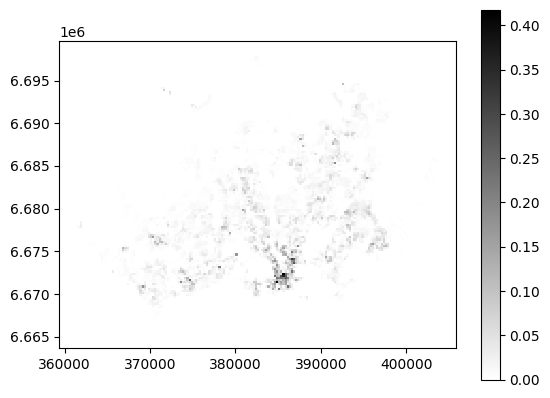

In [6]:
m = grid.merge(data, on="YKR_ID")
m.plot(column="H21", cmap="binary", legend=True)

In [7]:
minx, miny, maxx, maxy = tuple(map(round, grid.unary_union.bounds))
# make it square
maxy += 3000
miny -= 6500
print(maxy - miny)
print(maxx - minx)
area = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])

large = area.buffer(75000).envelope
large_crs = gpd.GeoDataFrame(geometry=[large], crs=CRS).geometry[0]
large_wgs84 = gpd.GeoDataFrame(geometry=[large], crs=CRS).to_crs(4326).geometry[0]


sx, sy = (maxx - minx) // rx, (maxy - miny) // ry

W, H = calculate_image_size(large_crs.bounds, rx, ry)
print(W, H)

42250
42250
769.0 769.0


In [8]:
area_grid = generate_grid(minx, maxx, miny, maxy, rx, ry, crs=CRS)
area_grid = area_grid.sjoin(grid_c, how="left").drop("index_right", axis=1)
area_grid.to_file(f"{output}/area_grid.geojson")

enriched_grid = area_grid.merge(data, on="YKR_ID", how="left")
enriched_grid["H21"] = enriched_grid["H21"].fillna(0)

In [242]:
# enriched_grid["H21"].hist(bins=np.arange(0, 0.02, 0.00025))

In [9]:
enriched_grid["H21_bin"] = enriched_grid["H21"].apply(lambda x: 1 if x > 0.0025 else 0)

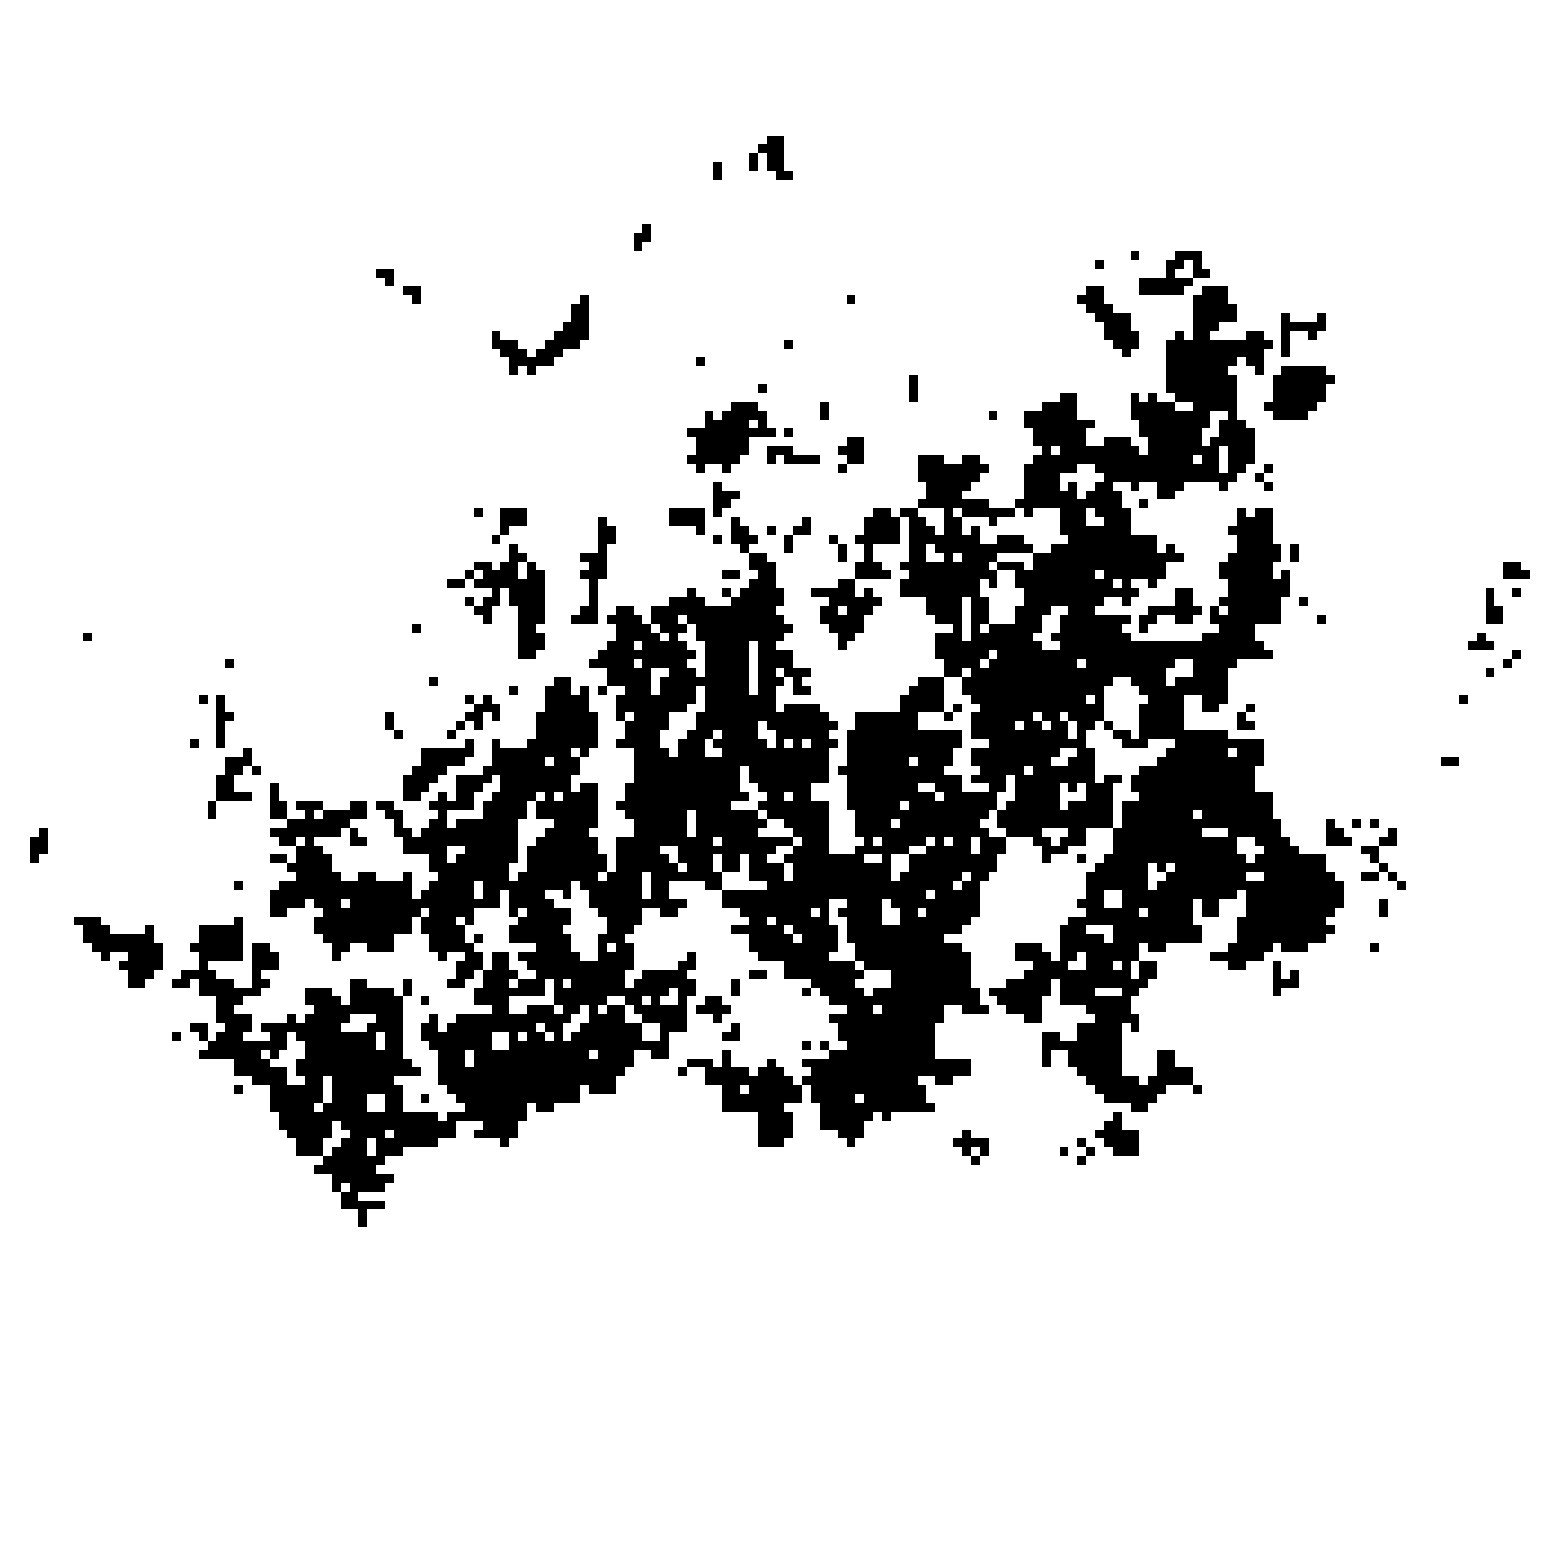

In [10]:
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
enriched_grid.plot(ax=ax, cmap="binary", column="H21_bin", zorder=5)
ax.margins(0)
ax.axis("off")
fig.savefig(
    f"{figures}/grid_binary.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

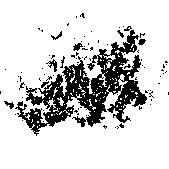

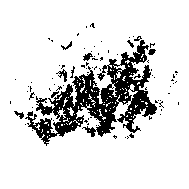

In [11]:
mx = rotate_90_cc(to_matrix(enriched_grid, value="H21_bin", shape=(169, 169)))

f_b, _ = plot_heatmap(mx, figsize=(sx, sy), dpi=1, cmap="binary")
f_b.savefig(
    f"{figures}/population_density_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(mx, figsize=(sx / 100, sy / 100), dpi=100, cmap="binary")
f_b.savefig(
    f"{figures}/population_density_binary_{rx}_{ry}_dpi_fixed.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [12]:
try:
    landuse = pd.read_pickle(
        f"{output}/landuse_crs.pickle",
    )
except FileNotFoundError:
    landuse = ox.features_from_polygon(
        large_wgs84, tags={"landuse": ["residential", "retail", "industrial"]}
    )
    landuse = landuse[landuse["geometry"].geom_type == "Polygon"].copy()
    landuse.to_crs(CRS, inplace=True)
    landuse.to_pickle(
        f"{output}/landuse_crs.pickle",
    )

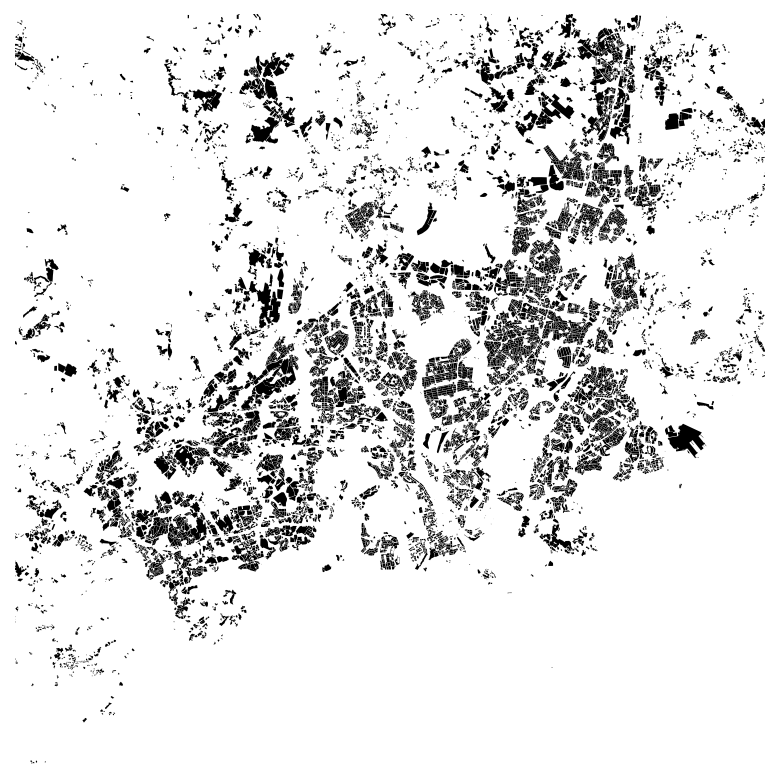

In [13]:
fig, ax = plot_landuse_img(landuse, large_crs, dpi=150)
ax.set_xlim([area.bounds[0], area.bounds[2]])
ax.set_ylim([area.bounds[1], area.bounds[3]])
fig.savefig(
    f"{figures}/landuse.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

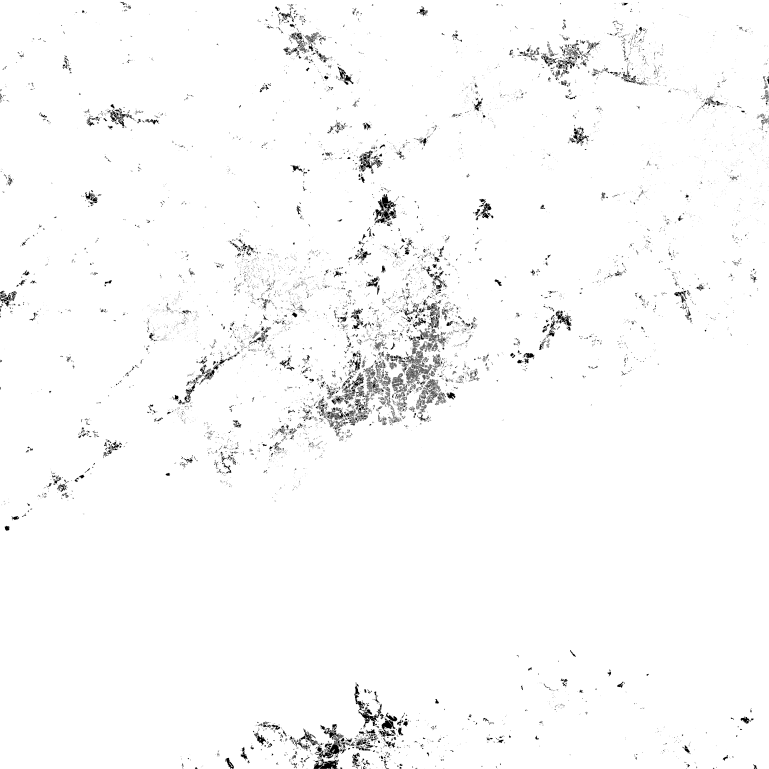

In [14]:
fig, _ = plot_landuse(landuse, large_crs, rx, ry)
fig.savefig(
    f"{figures}/large_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

(301, 299)


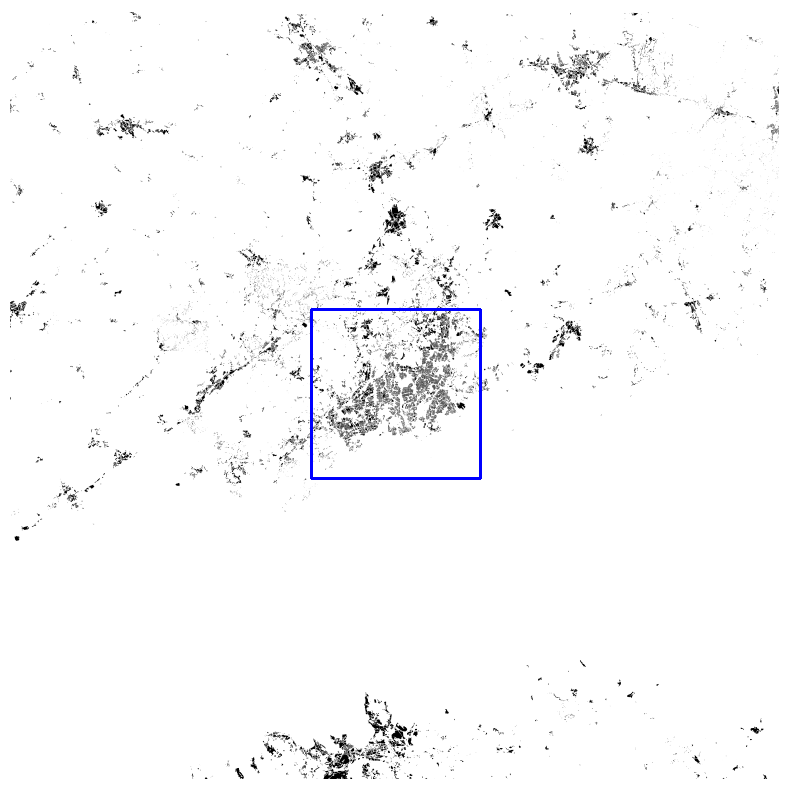

In [15]:
fig, _, top_left = locate(rx, ry, large_crs)
fig.savefig(
    f"{figures}/location_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [29]:
startx, starty = calculate_top_left_coordinates(large_crs, *top_left, rx, ry)
print(startx, starty)

save_anchor(area, large_crs, top_left, rx, ry)

361750.0 6701250.0


In [21]:
mx_t = rotate_90_cc(to_matrix(enriched_grid, value="H21", shape=(169, 169)))

grid_500 = merge_cells(mx_t, 2)

grid_500["bin"] = grid_500["value"].apply(lambda x: 1 if x > 0.0025 else 0)
mx_500 = to_matrix(
    grid_500, value="bin", shape=(math.ceil(169 / 2), math.ceil(169 / 2))
)

(151, 150)
(76, 75)
(38, 38)
(20, 20)


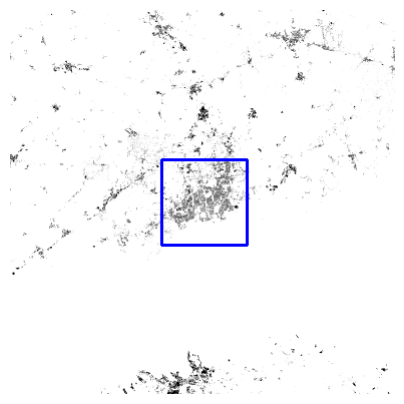

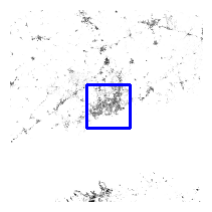

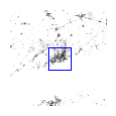

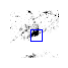

In [32]:
for i in (2, 4, 8, 16):
    mx = rotate_90_cc(to_matrix(enriched_grid, value="H21", shape=(169, 169)))
    grid_us = merge_cells(mx, i)
    grid_us["bin"] = grid_us["value"].apply(lambda x: 1 if x > 0.0025 else 0)
    mx_us = to_matrix(
        grid_us, value="bin", shape=(math.ceil(169 / i), math.ceil(169 / i))
    )

    fig_hm, _ = plot_heatmap(mx_us, figsize=mx_us.shape, dpi=1, cmap="binary")
    fig_hm.savefig(
        f"{figures}/population_density_{i*250}_{i*250}.png",
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"],
    )
    plt.close(fig_hm)

    fig_lu, _ = plot_landuse(landuse, large_crs, i * 250, i * 250)
    fig_lu.savefig(
        f"{figures}/large_{i * 250}_{i * 250}.png",
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"],
    )
    plt.close(fig_lu)

    fig, _, top_left = locate(i * 250, i * 250, large_crs)
    fig.savefig(
        f"{figures}/location_{i*250}_{i*250}.png",
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"],
    )
    save_anchor(area, large_crs, top_left, i * 250, i * 250)

In [25]:
loc25 = plt.imread(f"{figures}/location_250_250.png")
loc5h = plt.imread(f"{figures}/location_500_500.png")
loc1k = plt.imread(f"{figures}/location_1000_1000.png")
loc2k = plt.imread(f"{figures}/location_2000_2000.png")
loc4k = plt.imread(f"{figures}/location_4000_4000.png")
images = [loc25, loc5h, loc1k, loc4k]
images = [loc5h, loc1k, loc2k, loc4k]

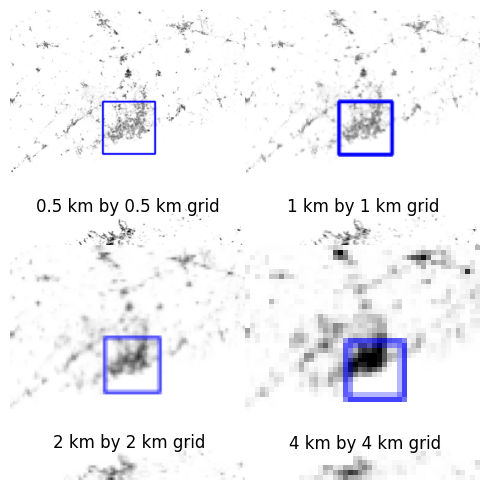

In [26]:
fig, axes = plt.subplots(
    figsize=(5, 5),
    nrows=2,
    ncols=2,
    layout="tight",
    gridspec_kw=dict(wspace=0, hspace=0),
    frameon=False,
)

for ax, img, label, a in zip(
    # axes.flat,
    # images,
    # [0.25, 0.5, 1, 4],
    # [round(769 / i) for i in [1, 2, 4, 16]],
    axes.flat,
    images,
    [0.5, 1, 2, 4],
    [384, 192, 96, 48],
):
    ax.imshow(img)
    ax.axis("off")
    ax.margins(0)
    ax.text(
        a / 2,
        a * 0.875,
        f"{label} km by {label} km grid",
        fontsize=12,
        ha="center",
        va="bottom",
    )
fig.savefig(
    f"{figures}/location_comparison.png",
    dpi=300,
    pad_inches=0,
    bbox_inches="tight",
    metadata=config["metadata"],
)